In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import regex as re
import numpy as np
from read_1t1r_data import read_1t1r_data

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# plt.style.use('ggplot')

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'dracula', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [2]:
folder = '.'

test_types = ['Reset_fail']
all_data = {}
for ttype in test_types:
    # recursively search the folder for excel files starting with ttype
    t, d, l = read_1t1r_data(folder, ttype)

    # sort the data by temerature and store it
    all_data[ttype] = sorted(list(zip(t,d)), key=lambda x:x[0])
    
    print(f"Found {len(d)} {ttype} Tests across {len(np.unique(t))} temperatures")

Found 29 Reset_fail Tests across 1 temperatures


## Reset Failure Analysis

In [5]:
# analyze memristor as if it's a state machine
LRS = []
HRS = []

plot_ivs = True

HRS_dict = {}
all_min_vs = []

read_v = 0.4
n_read_points = 8

for i, d in enumerate(all_data['Reset_fail']):
    if i != 24:
        continue
    current = []
    voltage = []
    for j, p in enumerate(d[1]):

        current.append(p[1])
        voltage.append(p[0])

    curr_LRS = []
    curr_HRS = []

    state = 'check_set'
    min_vs = []
    read_resistances = []

    i_sweeps = []
    v_sweeps = []

    i_sweeps.append([])
    v_sweeps.append([])
    for k, v in enumerate(voltage):
        v_sweeps[-1].append(v)
        i_sweeps[-1].append(current[k])
        # print(f'{state} {v} {min_vs} {read_resistances}')
        if state=='check_set' and v > 1:

            min_vs.append(None)
            state='read_lrs'
        elif state=='read_lrs' and v < read_v:

            read_resistances.append(v/current[k])
            if len(read_resistances) >= n_read_points:

                curr_LRS.append(np.mean(read_resistances))
                read_resistances = []
                state = 'find_min_v'
        elif state=='find_min_v':
            if min_vs[-1] is not None:
                if v > min_vs[-1]:
                    state = 'read_hrs'
                else:
                    min_vs[-1] = np.round(v,3)
            elif min_vs[-1] is None:
                min_vs[-1] = v
        elif state=='read_hrs' and v > -read_v:
            read_resistances.append(v/current[k])

            if len(read_resistances) >= n_read_points:
                
                curr_HRS.append(np.mean(read_resistances))


                if min_vs[-1] not in HRS_dict:
                    HRS_dict[min_vs[-1]] = []    
                    
                HRS_dict[min_vs[-1]].append(np.mean(read_resistances))
                state='check_set'
                read_resistances = []
                i_sweeps.append([])
                v_sweeps.append([])

    if state=='read_hrs' and len(read_resistances) >0:
        if min_vs[-1] not in HRS_dict:
            HRS_dict[min_vs[-1]] = []    
        HRS_dict[min_vs[-1]].append(np.mean(read_resistances))
        curr_HRS.append(np.mean(read_resistances))
    elif state=='read_lrs' and len(read_resistances) >0:
        curr_LRS.append(np.mean(read_resistances))

    if plot_ivs:
        l=1
        fig = plt.subplots(1,1,figsize=(7,4), dpi=1600)
        for m, Vs, Is in zip(min_vs, v_sweeps, i_sweeps):
            if int(m*100) % 20 == 0 or (m < -1.6 and int(m*100) % 20 == 0) or int(m*10) == -18:
                plt.plot(Vs, Is, label=f'Vreset={m}')
            l += 1

        # plt.title(f'{i}')
        plt.ylabel('Current (A)')
        plt.xlabel('Voltage (V)')
        # plt.yscale('log')
        plt.legend(loc=(1,0), ncol=2)

        plt.show()

    # print(min_vs)
    all_min_vs.append(min_vs)
    # break
    LRS.append(np.asarray(curr_LRS))
    HRS.append(np.asarray(curr_HRS))
        

print(f'Reset Operation has been tested on {len(all_min_vs)} devices with the following voltages:')
print(np.unique(all_min_vs))


Reset Operation has been tested on 1 devices with the following voltages:
[-2.   -1.95 -1.9  -1.85 -1.75 -1.7  -1.65 -1.6  -1.5  -1.45 -1.4  -1.35
 -1.25 -1.2  -1.15 -1.1  -1.   -0.95 -0.9  -0.8 ]


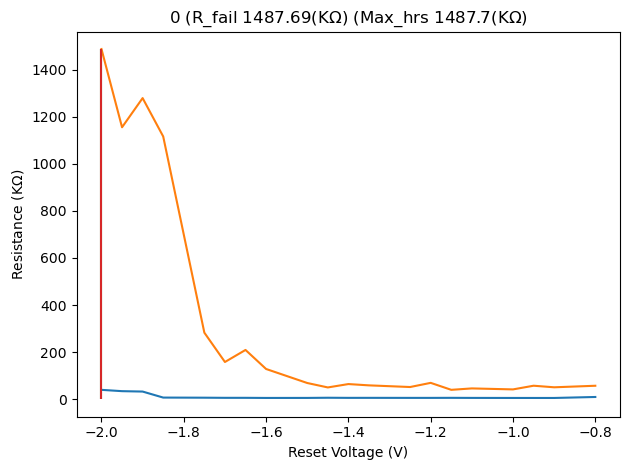

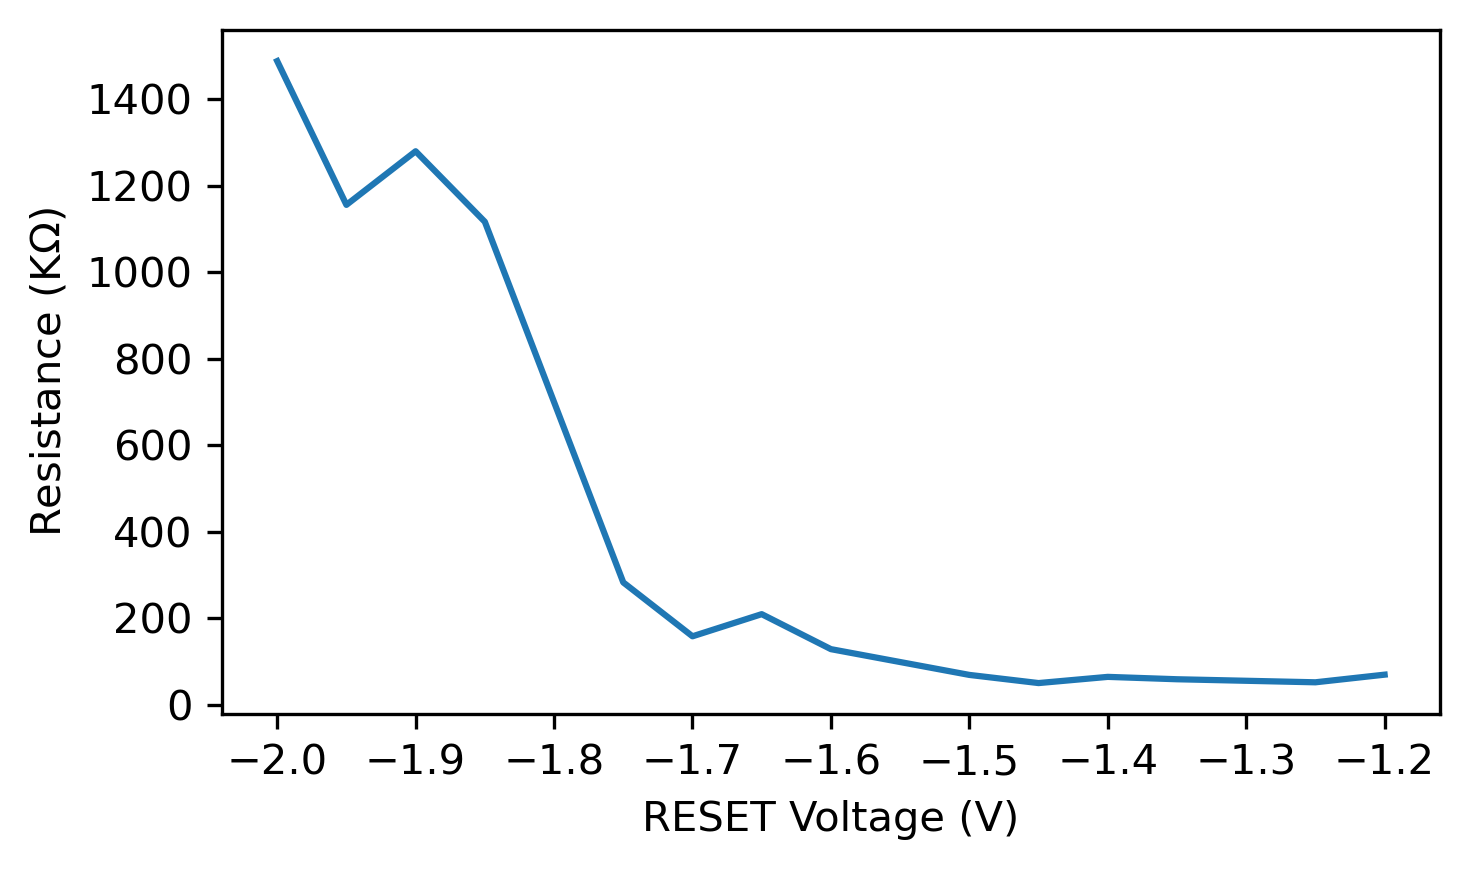

Reset Failure Voltage (1 devices):
	mean: -2.00 Volts
	std: 0.00000 Volts


In [4]:
# find reset fail voltages (reset voltage where the HRS is less than 10% of max)
Reset_fail_vs = []
plot_all_HRS=True
plot_median_HRS_failure_curve = True
for idx in range(len(HRS)):
    max_hrs = np.max(HRS[idx])
    R_fail = 0
    max_hrs_v = all_min_vs[idx][np.argmax(HRS[idx])]
    R_fail_v = 0
    for R, v in zip(HRS[idx], all_min_vs[idx]):
        if R > (max_hrs * 0.9):
            R_fail = R
            R_fail_v = v

    Reset_fail_vs.append(R_fail_v)

    if plot_all_HRS:
        plt.plot(all_min_vs[idx], LRS[idx]*1e-3, label='LRS')
        plt.plot(all_min_vs[idx], HRS[idx]*1e-3, label='HRS')
        plt.vlines(max_hrs_v, 0, max_hrs * 1e-3, color = 'tab:green')
        plt.vlines(R_fail_v, 0, R_fail * 1e-3, color='tab:red')
        plt.ylabel(r"Resistance (K$\Omega$)")
        plt.xlabel("Reset Voltage (V)")
        plt.title(f'{idx} (R_fail {R_fail * 1e-3:.2f}'+r'(K$\Omega$)' + f' (Max_hrs {max_hrs * 1e-3:.5}'+r'(K$\Omega$)')
        plt.show()



if plot_median_HRS_failure_curve:
    x = []
    y = []
    n_dev = 0
    for xi in sorted(HRS_dict.keys()):
        if xi >= -2.0 and xi <= -1.2:
                
            x.append(xi)
            y.append(np.median(HRS_dict[xi]))
            
            n_dev += len(HRS_dict[xi])

    fig, ax = plt.subplots(figsize=(5,3), dpi=300)
    plt.plot(x,np.asarray(y)*1e-3)
    plt.ylabel(r"Resistance (K$\Omega$)")
    plt.xlabel("RESET Voltage (V)")
    plt.savefig('HRS_vs_Vrst.pdf', bbox_inches='tight')
    plt.show()

print(f'Reset Failure Voltage ({len(Reset_fail_vs)} devices):\n\tmean: {np.mean(Reset_fail_vs):.2f} Volts\n\tstd: {np.std(Reset_fail_vs):.5f} Volts')